# Value Lost

A notebook to determine the value lost when applying a maintenance strategy defined in an asset model to the population with an explanation of the steps to gee there.

Requested: greg.bell@essentialenergy.com.au
Author: gavin.treseder@essentialenergy.com.au

## Contents
1. Project Setup
2. Load Data
3. Simulation
4. Sensitivity


## Project Setup
Several steps need to be completed to get the project ready for analysis
### Current Working Directory
Set the file path so that we can import pof code and load files

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

### Import packages

Import the packages that are required for this process 

In [2]:
import copy

from IPython.display import clear_output
import numpy as np 
import pandas as pd
import plotly.express as px

import scipy.stats as ss

from pof.system import System
from pof.interface import figures
from pof.interface.figures import make_sensitivity_fig
from pof.loader.asset_model_loader import AssetModelLoader
from pof.paths import Paths

%matplotlib inline

# Load Data
## Load the Asset Model
The asset model needs to be loaded from the excel file and converted into a component object that execute simulations

In [3]:
asset_model_filename = "Asset Model.xlsx"

paths = Paths()
model_path = paths.demo_path + os.sep + asset_model_filename

try:
    aml = AssetModelLoader()
    pof_data = aml.load(model_path)
    system = System.from_dict(pof_data['overhead_network'])
    comp = system.comp['pole']
    print("Asset Model loaded")
    pass
except:
    comp = Component.demo()
    print("Demo Model loaded")

Asset Model loaded


### Simulation - Single Event
See Failure Mode notebook

### Simulation - Monte Carlo 
The purpose of sensitivity is to understand the relationship between cost/risk/performance of a maintainence strategy when an input variable is changed. In previous notebooks we introduced the simulation concept and the outputs that can be produced. The length of time required to complete a sensitivity analysis is influenced by:
- t_end: the length of the time the each iteration is simulated to (sim time increases with t_end. Dependent on expected life and whether replacements occur)
- n_iterations: the number of iterations that are completed per simulation (sim time increases with n_iterations)
- model_units: the time units to use when completing a simmulation (sim time increases with smaller units)
The simulation is below has been set to complete quickly to demonstrate functionality

In [4]:
t_end = 100
n_iterations = 100
model_units = 'years'

In [5]:
comp.units = model_units
comp.mc_timeline(t_end=t_end, n_iterations=n_iterations)
comp.expected_risk_cost_df()
comp.plot_ms()

### Sensitivity
The purpose of sensitivity is to understand the relationship between cost/risk/performance of a maintainence strategy when an input variable is changed. It is influence by the following parameters
- var_id: the variable id for which sensitivity is going to be adjusted.
- lower: the lower limit for the var_id
- upper: the upper limit for the var_id
- step_size: the size of the increments that are going to be used
The length of time required to complete a sensitivity analysis is influenced by t_end, n_iterations and model_units. The simulation is below has been set to complete quickly to demonstrate functionality.

In [7]:
var_id = 'pole-task_group_name-groundline-t_interval'
lower = 0
upper = 10 
step_size = 1

In [8]:
comp.expected_sensitivity(var_id, lower, upper, step_size, n_iterations, t_end)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

## Determine Parameters that have the greatest impact
Considering the impact of all sensitivities at the same time results in a large computational burden. Considering the sensitivity of each parameters in isolation first allows parameters that have limited impact to be ignored and the focus shifted to high impact parameters.


In [9]:
#TODO update illyses code
# conf = 0.9
# n_increments = 10
# n_iterations = 100

# #if it's even add one
# df_sens = comp.sensitivity(var_name = df_inspection_slow, conf =  conf, n_increments = n_increments, n_iterations = n_iterations)

# comp.make_sensitivity_plot(
#     data = df_sens,
#     x_axis = 'conf',
#     y_axis = 'var_name',
#     failure_mode = 'slow_aging',
#     plot_type = 'heatmap',
#     z_axis = 'risk_cost',
# )

## Investigate the relationship between multiple parameters

There are often situations where the relationship between multiple parameters need to be considered at the same time. Creating a sesnitivity chain becomes computationally expensive so should only be considered for parameters that have a known impact.

- sens_vars: A dictionary of variables to chain with a list of values to evaluate.

The lists can be generated using three methods:
- [list][1]: a list of values to use
- [np.arange][2]: a list of numbers between *start* and *stop* at every *step* 
- [np.linspace][3]: a list of numbers between *start* and *stop* broken up into *num* increments

These three methods are equivalent:
~~~ python
sens_vars = {
    'var_list' : [0, 2, 4, 6, 8, 10],
    'var_arange' : np.arange(start = 0, stop = 11, step = 2), #parameter names are optional
    'var_linspace' : np.linspace(start = 0, stop = 10, num = 6) #parameter names are optional
}
~~~
[1]: https://docs.python.org/3/tutorial/datastructures.html
[2]: https://numpy.org/doc/stable/reference/generated/numpy.arange.html
[3]: https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace

In [6]:
sens_vars = {
    'pole-consequence-cost': np.arange(0, 2e6,5e5),
    'pole-task_group_name-groundline-t_interval': np.arange(0, 10, 1),
}
sens_vars

{'pole-consequence-cost': array([      0.,  500000., 1000000., 1500000.]),
 'pole-task_group_name-groundline-t_interval': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [7]:
df_sens_chain = comp.sensitivty_chain(sens_vars, t_end=t_end, n_iterations=n_iterations)
df_sens_chain.head()

KeyboardInterrupt: 

### Rolling mean
Increasing the number of iterations to reduce the 'spikeiness' of the sensitivity charts is not always feasabily. To reduce simulation times, it can be beneficial to use a rolling mean to smooth out the profile and more easily identify trends, minimums or maximums.

In [10]:
x_var = var_id
y_var = 'pole-consequence-cost'
window=5

In [11]:
def rolling_mean(df, window=5):
    """ Returns a df with a rolling mean"""
    #TODO set this up so it work for 
    df_results = (
        df.copy(deep=True)
        .rename(columns={'task':'source'})
        .dropna()
    )

    # Generate a rolling average
    df_rolling = (
        df_results
        .sort_values(by=['source', x_var, y_var])
        .groupby(by=['source', y_var]).rolling(window).mean()
        .drop([y_var], axis=1)
        .reset_index()
        .dropna()
    )

    df_rolling['active'] = df_rolling['active'].astype(bool)

    return df_rolling


In [104]:
comp.expected_risk_cost_df()

,failure_mode,task,active,time,quantity,cost,cost_cumulative,cost_annual,quantity_cumulative,quantity_annual
28,termites,risk,True,0,0,0,0,0,0,0
29,fungal decay | external,risk,True,0,0,0,0,0,0,0
30,fungal decay | internal,risk,True,0,0,0,0,0,0,0
31,lightning,risk,True,0,0,0,0,0,0,0
32,weathering,risk,True,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
45,lightning,inspection_protection,True,100,0,0,0,0,7.96163,0
47,fire_damage,inspection_protection,True,100,0,0,0,0,7.96163,0
48,impact,inspection_protection,True,100,0,0,0,0,7.96043,0
37,fungal decay | internal,pole_saver_rod,False,100,0,0,0,0,0,0


In [12]:
# Apply the function
df_rolling = rolling_mean(df_sens_chain, window=window)

# Create df_plot for generating a figure
df_plot = df_rolling.loc[df_rolling[y_var] == df_rolling.iloc[-1][y_var]]
df_plot.rename(columns={x_var : x_var.split('-')[-1]}, inplace=True)
make_sensitivity_fig(df_plot, var_name=x_var, y_axis = 'cost_cumulative')

In [88]:
def calc_value_lost(df, x_var:str, y_var:str):
    """ Takes a df of risk costs and returns a df with teh value lost
    # TODO move this to risk cost
    # TODO check y_var and x_var are the right way around
    """

    # Calculate the total cost for each scenario
    df = df_rolling.groupby(by=[x_var, y_var])['quantity', 'cost', 'quantity_annual', 'cost_annual'].sum()

    # Calculate the value_lost at each interval
    df['value_lost'] = df['cost'] - df.groupby(by=[y_var])['cost'].min()

    return df

In [89]:
df_total = calc_value_lost(df=df_rolling, x_var='pole-task_group_name-groundline-t_interval', y_var='pole-consequence-cost')

# Plot the results to check it works 
px.line(df_total.reset_index(), x='pole-task_group_name-groundline-t_interval', y = 'value_lost', color='pole-consequence-cost')

In [90]:
def make_contour_plot(df, x_axis, y_axis, z_axis):
    """ Create a contour plot """

    df_plot = df.reset_index()

    # Arrange the data for plotly
    z = df_plot.groupby(by = [x_axis])[z_axis].apply(lambda x: x.values.tolist()).tolist()
    x = df_plot[x_axis].unique()
    y = df_plot[y_axis].unique()

    # Generate the figure
    fig = go.Figure(
        data = go.Contour(x=x, y=y, z=z, contours_coloring='lines'),
    )
    return fig

In [91]:
x_axis = 'pole-task_group_name-groundline-t_interval'
y_axis = 'pole-consequence-cost'
z_axis = 'value_lost'

make_contour_plot(df_total, x_axis=x_axis, y_axis=y_axis, z_axis=z_axis)

# Match Asset Models to the population
## Load the population data

In [13]:
filename = r"C:\Users\gtreseder\OneDrive - KPMG\Documents\3. Client\Essential Energy\Probability of Failure Model\inputs\csvs\ACS - Poles - Consequence Model Output.csv"
print("File Loading...")
df_cons = pd.read_csv(filename)
clear_output()
print("File Loaded")
df_cons.head()

File Loaded


,Unnamed: 0,ASSET_ID,Depot (ZSG Area),Pole_LU_NSWMajo,Pole_LU_NSWDeta,Pole_LU_ALUMMaj,Pole_LU_ALUMDet,Road Crossing Conductor Type,HV_LV Status,BushfirePriority,...,C_Environment_Rank,Site_Bushfire_Moderate_Probability,Site_Bushfire_Severe_Probability,C_Bushfire_Dollars,Site_Environment_Insignificant_Probability,Site_Environment_Minor_Probability,C_Environment_Dollars,C_Financial_Dollars,Total Consequence $,Radial(Y/N)
0,0,388,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2802.19134,21198.144867,NaN
1,1,389,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2802.57978,21198.533307,NaN
2,2,390,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2803.09692,21199.050447,NaN
3,3,391,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2803.76382,21199.717347,NaN
4,4,392,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2804.33010,21200.283627,NaN


## Match to the closest model
S

In [14]:
# TODO turn ino a function so it works for mutliple y vars

pop_var = 'Total Consequence $'
sens_var = 'pole-consequence-cost'
df_sens_var = pd.DataFrame(sens_vars[sens_var], columns= [sens_var])

# Fill with average val
df_cons[pop_var] = df_cons[pop_var].fillna(df_cons[pop_var].mean())

# Match to the closest value from the model
df = pd.merge_asof(
    df_cons.sort_values(pop_var),
    df_sens_var,
    left_on = pop_var,
    right_on = sens_var,
    direction = 'forward'
)

In [18]:
df

,Unnamed: 0,ASSET_ID,Depot (ZSG Area),Pole_LU_NSWMajo,Pole_LU_NSWDeta,Pole_LU_ALUMMaj,Pole_LU_ALUMDet,Road Crossing Conductor Type,HV_LV Status,BushfirePriority,...,Site_Bushfire_Moderate_Probability,Site_Bushfire_Severe_Probability,C_Bushfire_Dollars,Site_Environment_Insignificant_Probability,Site_Environment_Minor_Probability,C_Environment_Dollars,C_Financial_Dollars,Total Consequence $,Radial(Y/N),pole-consequence-cost
0,1070889,2766284,Warialda Depot,Tree & Shrub Cover,Native forest,Other minimal use,Residual native cover,NaN,NaN,P3,...,0.000715,0.000005,755.419255,0.0,0,0,2771.57244,4.460796e+03,NaN,500000.0
1,1014307,2706503,Warialda Depot,Tree & Shrub Cover,Native forest,Other minimal use,Residual native cover,NaN,NaN,P3,...,0.000715,0.000005,755.419255,0.0,0,0,2771.94450,4.461168e+03,NaN,500000.0
2,881522,2565300,Texas Depot,NaN,NaN,NaN,NaN,NaN,NaN,P3,...,0.000715,0.000005,755.419255,0.0,0,0,2772.07086,4.461294e+03,NaN,500000.0
3,880595,2564350,Texas Depot,NaN,NaN,NaN,NaN,NaN,NaN,P3,...,0.000715,0.000005,755.419255,0.0,0,0,2772.15510,4.461378e+03,NaN,500000.0
4,882559,2566388,Texas Depot,NaN,NaN,NaN,NaN,NaN,NaN,P3,...,0.000715,0.000005,755.419255,0.0,0,0,2772.29082,4.461514e+03,NaN,500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400152,69484,74840,Nyngan Depot,Power Generation,Electricity substation,Utilities,Fuel powered electricity generation,None,HV Only,P2,...,0.001010,0.000255,11655.739430,0.0,0,0,2776.33668,9.499943e+06,Yes,NaN
1400153,1365051,4082929,Nyngan Depot,Cropping,Cropping - continuous or rotation,Cropping,Cropping,None,HV Only,P2,...,0.001010,0.000255,11655.739430,0.0,0,0,2805.45564,9.504958e+06,Yes,NaN
1400154,1365070,4082954,Nyngan Depot,Cropping,Cropping - continuous or rotation,Cropping,Cropping,None,HV Only,P2,...,0.001010,0.000255,11655.739430,0.0,0,0,2815.44042,9.504967e+06,Yes,NaN
1400155,121487,189068,Orange Depot,Mining & Quarrying,Mine site,Mining,Mines,None,HV Only,P1,...,0.004030,0.002290,100844.361290,0.0,0,0,2831.94210,1.099299e+07,Yes,NaN


In [21]:
df_rolling

,source,pole-consequence-cost,level_2,active,quantity,quantity_annual,quantity_cumulative,cost,cost_annual,cost_cumulative,pole-task_group_name-groundline-t_interval
4,risk,0.0,57,True,0.012,0.000157,0.042,0.0,0.000000,0.0,2.0
5,risk,0.0,71,True,0.012,0.000159,0.040,0.0,0.000000,0.0,3.0
6,risk,0.0,85,True,0.012,0.000158,0.034,0.0,0.000000,0.0,4.0
7,risk,0.0,99,True,0.012,0.000159,0.042,0.0,0.000000,0.0,5.0
8,risk,0.0,113,True,0.012,0.000160,0.048,0.0,0.000000,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
275,termite_treatment,1500000.0,503,True,0.026,0.000343,0.198,2.6,0.034345,19.8,3.0
276,termite_treatment,1500000.0,517,True,0.030,0.000397,0.196,3.0,0.039668,19.6,4.0
277,termite_treatment,1500000.0,531,True,0.032,0.000423,0.190,3.2,0.042287,19.0,5.0
278,termite_treatment,1500000.0,545,True,0.040,0.000531,0.194,4.0,0.053110,19.4,6.0


### Count assets within each subpopluation
To speed up execution the code, the number of assets within each group can be combined 

In [142]:
#TODO make it work for multiple y vars
df_pop = df.groupby(by=['Depot (ZSG Area)', y_var])['ASSET_ID'].count().reset_index()
df_pop.head()

,Depot (ZSG Area),pole-consequence-cost,ASSET_ID
0,Albury Depot,500000.0,19568
1,Albury Depot,1000000.0,9
2,Albury Depot,1500000.0,361
3,Armidale Depot,500000.0,18941
4,Armidale Depot,1000000.0,7


In [119]:
df_results = pd.read_csv("results.csv")

df_plot = df_results.loc[df_results['consequence-cost'] == 5e5]

make_sensitivity_fig(df_plot, var_name='t_interval', y_axis = 'cost_cumulative')


## Insights
Insights should be run with an emphasis on accuracy rather than simulation time and have each been set up with high iteration counts

### Impact of improving inspection effectiveness

In [ ]:
var_id = 'pole-task_group_name-inspection_groundline-p_effective'
comp.expected_sensitivity(var_id = var_id, lower = 0.1, upper = 1, step_size= 0.1, n_iterations=1000, t_end=100)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

### Min effectiveness for Pole Saver Rod

In [ ]:
# Turn on Pole Saver Rod
comp.fm['fungal decay | internal'].tasks['pole_saver_rod'].active = True

# Run simulation
var_id = 'pole-task_group_name-inspection_groundline-p_effective'
comp.expected_sensitivity(var_id = var_id, lower = 0.1, upper = 1, step_size= 0.1, n_iterations=1000, t_end=100)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

# Turn off Pole Save Rod
comp.fm['fungal decay | internal'].tasks['pole_saver_rod'].active = False

## Long run simulation 
Run a long simulation to repeat the process above for the key outputs without the interim steps

In [94]:
# Set the parameters
t_end = 100
n_iterations = 1000
model_units = 'months'
sens_vars = {
    'pole-consequence-cost': np.arange(0, 2e6, 2e5),
    'pole-task_group_name-groundline-t_interval': np.arange(0, 10, 0.25)
}

x_var = 'pole-task_group_name-groundline-t_interval'
y_var = 'pole-consequence-cost'
z_var = 'value_lost'

window=5

In [95]:
# Run the simulation
comp.units = model_units

df_sens_chain = comp.sensitivty_chain(sens_vars, t_end=t_end, n_iterations=n_iterations)

df_rolling = rolling_mean(df_sens_chain, window=window)

df_total = calc_value_lost(df=df_rolling, x_var='pole-task_group_name-groundline-t_interval', y_var='pole-consequence-cost')

KeyboardInterrupt: 

## Original - Simple Version

In [31]:
def expected_inspection_interval(x_min, x_max, n_iterations=100, t_end=100):
    """
    A simple method for returning the impact of changing an inspection interval. 
    TODO not needed now the method has been moved to the object expected sensitivities
    """
    rc = dict()
    comp.reset()

    for i in range(max(1, x_min),x_max,1):

        # Set t_interval
        for fm in comp.fm.values():
            if 'inspection' in list(fm.tasks):
                fm.tasks['inspection'].t_interval = i
        
        comp.mc_timeline(t_end=t_end, n_iterations=n_iterations)

        risk_cost = comp.expected_risk_cost_df().groupby(by=['task'])['cost'].sum()
        rc[i] = dict(risk_cost)
        rc[i]['inspection_interval'] = i

        # Reset component
        comp.reset()

    df = pd.DataFrame().from_dict(rc, orient='index')
    df['total_cost'] = df.drop(['inspection_interval', 'risk'], axis=1).sum(axis=1)
    df['total'] = df['total_cost'] + df['risk']
    
    return df

In [32]:
df = expected_inspection_interval(0, 10, 10)
clear_output()
df.head()

,risk,conditional_failure,functional_failure,inspection_groundline,inspection_protection,pole_saver_rod,termite_treatment,inspection_interval,total_cost,total
1,0.0,2100.0,0.0,870.0,0.0,0.0,20.0,1,2990.0,2990.0
2,5000.0,2450.0,700.0,915.0,0.0,0.0,30.0,2,4095.0,9095.0
3,15000.0,1750.0,2100.0,850.0,0.0,0.0,40.0,3,4740.0,19740.0
4,10000.0,1400.0,1400.0,930.0,0.0,0.0,10.0,4,3740.0,13740.0
5,0.0,2800.0,0.0,870.0,0.0,0.0,10.0,5,3680.0,3680.0


## Populations - Consequence
We will consider the different consequence assets as a different 

In [33]:
filename = r"C:\Users\gtreseder\OneDrive - KPMG\Documents\3. Client\Essential Energy\Probability of Failure Model\inputs\csvs\ACS - Poles - Consequence Model Output.csv"
print("File Loading...")
df_cons = pd.read_csv(filename)
clear_output()
print("File Loaded")

File Loaded


Break the consequences up into groups so they can be passed into the model

In [34]:
def get_bin_groups(df, bin_on='Total Consequence $', group_by='ASSET_ID', n_bins = 5):
    """ Groups an attribute"""

    df['bin_consequence'] = pd.qcut(df['Total Consequence $'], q=3, labels=['low', 'med', 'high'])
    #pd.qcut(df_cons['Total Consequence $'], q=3, labels=['low', 'med', 'high'], retbins=True)

    groups = df.groupby(by='bin_consequence').count()

    return df

In [35]:
df_bins = get_bin_groups(df_cons)
df_bins.groupby(by='bin_consequence').count().head()

,Unnamed: 0,ASSET_ID,Depot (ZSG Area),Pole_LU_NSWMajo,Pole_LU_NSWDeta,Pole_LU_ALUMMaj,Pole_LU_ALUMDet,Road Crossing Conductor Type,HV_LV Status,BushfirePriority,...,C_Environment_Rank,Site_Bushfire_Moderate_Probability,Site_Bushfire_Severe_Probability,C_Bushfire_Dollars,Site_Environment_Insignificant_Probability,Site_Environment_Minor_Probability,C_Environment_Dollars,C_Financial_Dollars,Total Consequence $,Radial(Y/N)
bin_consequence,,,,,,,,,,,,,,,,,,,,,
low,459243,459243,459243,444182,444181,444182,444182,398918,398918,459243,...,459243,459243,459243,459243,459243,459243,459243,459243,459243,373
med,459243,459243,459243,457207,457202,457207,457207,436810,436810,459243,...,459243,459243,459243,459243,459243,459243,459243,459243,459243,446
high,459243,459243,459243,454364,454213,454364,454364,436925,436925,459243,...,459243,459243,459243,459243,459243,459243,459243,459243,459243,57316


# Grouping for impact
To understand the impact of different strategies at scale we will consider a depot lense

In [36]:
depots = ['Young Depot', 'Temora Depot', 'Yass Depot', 'Young Depot', 'Bathurst Depot']

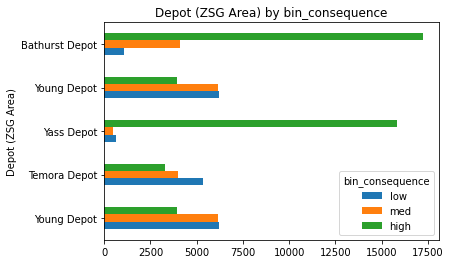

In [37]:
index = 'Depot (ZSG Area)'
columns = 'bin_consequence' #'BushfirePriority'

consequence = df_bins.pivot_table(index=index, columns= columns, values = 'ASSET_ID', aggfunc=len).fillna(0).astype(int)
consequence.loc[depots].plot(kind='barh', title=f'{index} by {columns}');

Using 

In [39]:

def update_inspection_interval_figure():
    
    df = expected_inspection_interval(lower=1, upper=10, n_iterations=1000)
    df_plot = df.melt(id_vars='inspection_interval', var_name = 'source', value_name='cost')
    fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
    return fig

clear_output(True)
update_inspection_interval_figure().show()

100%|██████████| 1000/1000 [01:35<00:00, 10.51it/s]


In [28]:
def df_all_generator(by, col, sens_var, n_iterations=1000, t_min=1, t_max=5, t_end=100):
    """
    This function generates df_all
    """
    scen = dict()

    category_value = df_bins.groupby(by=by)[col].mean()

    for category, value in zip(category_value.index, category_value.to_numpy().astype(int)):
        comp = Component.demo()

        # Update consequence for all the failure modes
        for fm in comp.fm.values():
            fm.consequence.risk_cost_total = value

        scen[category] = comp.expected_sensitivity(t_min, t_max, n_iterations, t_end)

    df_all = pd.concat(scen).reset_index()
    df_all = df_all.rename(columns = {'level_0':by, 'level_1':sens_var})

    # Check there aren't any duplictes #TODO remove when changing to sensitivity
    df_all = df_all.loc[:,~df_all.columns.duplicated()]
    #TODO will need to get total time from components
    df_all['annual_value_lost'] = (df_all['total'] - df_all.groupby(by =by)['total'].transform('min'))/t_end # time considered

    # clear_output(True)
    return df_all

In [30]:
by = 'bin_consequence'
col = 'Total Consequence $'
sens_var = 'inspection_interval'

df_all = df_all_generator(by = by, col = col, sens_var = sens_var)

df_all.head()

AttributeError: 'int' object has no attribute 'split'

In [13]:

df_plot = df_all
fig = px.line(df_plot, x=sens_var, y="annual_value_lost", color=by, title=f'Risk v Cost at different {sens_var}', color_discrete_sequence=px.colors.qualitative.Vivid)
fig.show()

## Map to the population
Each asset can look up the model that most closely relates to it to get the value_lost for different strategies

In [14]:
df_pop = df_bins.groupby(by=['Depot (ZSG Area)', by])['ASSET_ID'].count().reset_index()
df_pop.head()

,Depot (ZSG Area),bin_consequence,ASSET_ID
0,Albury Depot,low,5350
1,Albury Depot,med,6560
2,Albury Depot,high,7497
3,Armidale Depot,low,7819
4,Armidale Depot,med,6628


In [15]:
y_var = 'annual_value_lost'
df_map = df_all[[by, sens_var, y_var]]
df_map.head()

,bin_consequence,inspection_interval,annual_value_lost
0,low,1,13.26
1,low,2,0.00
2,low,3,6.85
3,low,4,35.00
4,med,1,25.34


In [16]:
df_pop_map = df_pop.merge(df_map, on=by, how='outer')
df_pop_map.head()

,Depot (ZSG Area),bin_consequence,ASSET_ID,inspection_interval,annual_value_lost
0,Albury Depot,low,5350,1,13.26
1,Albury Depot,low,5350,2,0.00
2,Albury Depot,low,5350,3,6.85
3,Albury Depot,low,5350,4,35.00
4,Armidale Depot,low,7819,1,13.26


In [17]:
df_pop_map['total_value_lost'] = (df_pop_map.ASSET_ID * df_pop_map.annual_value_lost).where(df_pop_map.bin_consequence == 'high').fillna(0)
df_pop_map['total_value_lost'] = df_pop_map['total_value_lost'] + (df_pop_map.ASSET_ID * df_pop_map.annual_value_lost).where(df_pop_map.bin_consequence != 'high').fillna(0)
df_pop_map.head()

,Depot (ZSG Area),bin_consequence,ASSET_ID,inspection_interval,annual_value_lost,total_value_lost
0,Albury Depot,low,5350,1,13.26,70941.00
1,Albury Depot,low,5350,2,0.00,0.00
2,Albury Depot,low,5350,3,6.85,36647.50
3,Albury Depot,low,5350,4,35.00,187250.00
4,Armidale Depot,low,7819,1,13.26,103679.94


In [18]:
optimum_inspection = df_pop_map.groupby(by=['Depot (ZSG Area)', 'inspection_interval'])['total_value_lost'].sum().reset_index()

In [19]:
optimum_inspection = optimum_inspection.loc[optimum_inspection['Depot (ZSG Area)'].isin(depots)]

fig = px.line(
    optimum_inspection,
    x="inspection_interval",
    y="total_value_lost",
    color="Depot (ZSG Area)",
    title= 'Optimum Inspection Interval by Depot'
)
fig

In [20]:
optimum_inspection.groupby(by=['Depot (ZSG Area)']).min()

,inspection_interval,total_value_lost
Depot (ZSG Area),,
Bathurst Depot,1,0.0
Temora Depot,1,0.0
Yass Depot,1,0.0
Young Depot,1,0.0


In [40]:
comp.fm["fast_aging"].tasks["inspection"].cost = 1000
comp.fm["fast_aging"].tasks["inspection"].cost

1000

In [5]:
conf = 0.9
n_increments = 10
n_iterations = 100
#if it's even add one

df_sens = comp.sensitivity(var_name = df_inspection_slow, conf =  conf, n_increments = n_increments, n_iterations = n_iterations)

comp.make_sensitivity_plot(data = df_sens, x_axis = 'conf', y_axis = 'var_name', failure_mode = 'slow_aging', plot_type = 'heatmap', z_axis = 'risk_cost')


100%|██████████| 100/100 [00:03<00:00, 31.13it/s]
